In [1]:
import numpy as np
import pylab as pl
import os
import pandas as pd
import glob
from mvpa2.datasets.mri import fmri_dataset

In [2]:
# little helper function to plot dissimilarity matrices
# since we are using correlation-distance, we use colorbar range of [0,2]
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0, 2))
    pl.colorbar()

In [5]:
bids_dir = '/data/projects/relationship_knowledge/'
os.chdir(bids_dir)

output_dir = os.path.join(bids_dir, 'derivatives', 'rsa_theory_comps')
data_dir = os.path.join(bids_dir, 'derivatives','relscenarios_all')

# Input subject list
subjs_scan_info = pd.read_csv(output_dir+'/mriqc_summary_poor.csv')
subjs_list = list(subjs_scan_info['subject'].unique())

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

# Find beta maps
file_list = glob.glob(os.path.join(data_dir, subj, 'beta*nii'))
file_list.sort()
file_list = file_list[:-2]
betas = fmri_dataset(file_list, mask=mni_mask_fname)
print('Found '+str(len(betas))+' beta maps')


# Define mask
mni_mask_fname = 'derivatives/reliability_analysis/relscenarios/Anatomy/MNI152_T1_2p5mm_brain_gm_mask.nii.gz'

Found 36 subjects
 * Please note: warnings are printed only once, but underlying problem might occur many times *
Found 76 beta maps


Find conditions (stimuli for the study). In this case, the beta maps were numbered by referencing the order of stimuli for the first run of the first subject.

In [6]:
conditions = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
conditions = conditions.columns.tolist()[:76]
conditions = [x[:-3] for x in conditions]
conditions = [x.rstrip() for x in conditions]
len(conditions)

76

In [7]:
betas.sa.targets = np.array(conditions)

# Basic ROI RSA -- dissimilarity matrix for the entire ROI

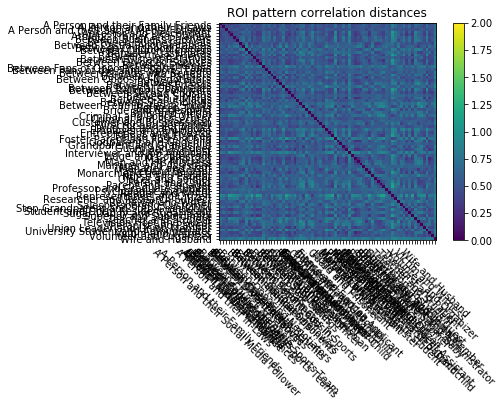

In [8]:
from mvpa2.measures import rsa
dsm = rsa.PDist(square=True)
res = dsm(betas)
plot_mtx(res, betas.sa.targets, 'ROI pattern correlation distances')

# Searchlight fashion

In [9]:
from mvpa2.measures.searchlight import sphere_searchlight
dsm = rsa.PDist(square=False)
sl = sphere_searchlight(dsm, 2)
slres = sl(betas)

## score each searchlight sphere result wrt global pattern dissimilarity

Most dissimilar patterns around [20 45 13]


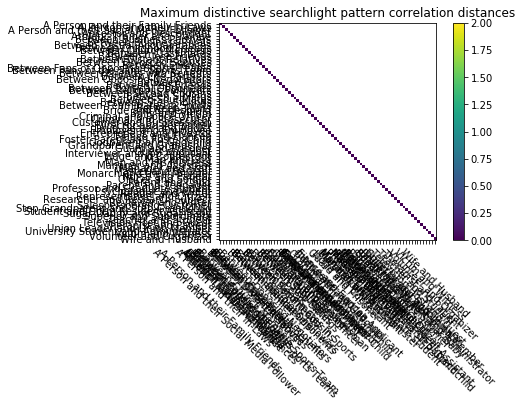

In [10]:
distinctiveness = np.sum(np.abs(slres), axis=0)
print 'Most dissimilar patterns around', \
        betas.fa.voxel_indices[distinctiveness.argmax()]
# take a look at the this dissimilarity structure
from scipy.spatial.distance import squareform
plot_mtx(squareform(slres.samples[:, distinctiveness.argmax()]),
         betas.sa.targets,
         'Maximum distinctive searchlight pattern correlation distances')

## searchlight consistency measure
how correlated are the structures across runs

In [12]:
dscm = rsa.PDistConsistency()
sl_cons = sphere_searchlight(dscm, 2)

# Import PCA Dimensions

### Formality

In [14]:
# Import distance matrix from theoretical components analysis
comp1_dist = pd.read_csv(output_dir+'/comp1_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
conditions = [x.lower() for x in conditions]
comp1_dist.columns = [x.lower() for x in comp1_dist.columns]
comp1_dist.index = [x.lower() for x in comp1_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp1_dist.columns = comp1_dist.columns.str.replace('–','and')
comp1_dist.index = comp1_dist.index.str.replace('–','and')
comp1_dist.columns = comp1_dist.columns.str.replace(' - ',' and ')
comp1_dist.index = comp1_dist.index.str.replace(' - ',' and ')
comp1_dist.columns = comp1_dist.columns.str.replace('  ',' ')
comp1_dist.index = comp1_dist.index.str.replace('  ',' ')
comp1_dist.columns = comp1_dist.columns.str.replace('between ','')
comp1_dist.index = comp1_dist.index.str.replace('between ','')
comp1_dist = comp1_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister',
                                             'researcher and research-subject': 'researcher and research subject',
                                              'union-leader and union-member': 'union leader and union member',
                                              'monarch and minister': 'monarch and their minister',
                                              'person and family friends': 'a person and their family friends',
                                              'friends-with-benefits': 'friends with benefits',
                                              'childhood-friends': 'childhood friends',
                                              'distant-relatives': 'distant relatives',
                                              'close-friends': 'close friends',
                                              'person and their social media follower': 'a person and their social media follower',
                                              'student and dorm-resident-assistant': 'student and dorm resident assistant',
                                              'second-cousins': 'second cousins'}, 
                                   index = {'a monarch and their minister': 'monarch and their minister',
                                             'researcher and research-subject': 'researcher and research subject',
                                              'union-leader and union-member': 'union leader and union member',
                                              'monarch and minister': 'monarch and their minister',
                                              'person and family friends': 'a person and their family friends',
                                              'friends-with-benefits': 'friends with benefits',
                                              'childhood-friends': 'childhood friends',
                                              'distant-relatives': 'distant relatives',
                                              'close-friends': 'close friends',
                                              'person and their social media follower': 'a person and their social media follower',
                                              'student and dorm-resident-assistant': 'student and dorm resident assistant',
                                              'second-cousins': 'second cousins'})

conditions = [x.replace('between ','') for x in conditions]

comp1_dist = comp1_dist[conditions].loc[conditions]

comp1_upper = np.triu(np.array(comp1_dist)).flatten()
comp1_upper = comp1_upper[comp1_upper != 0]

### Activeness

In [15]:
# Import distance matrix from theoretical components analysis
comp2_dist = pd.read_csv(output_dir+'/comp2_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp2_dist.columns = [x.lower() for x in comp2_dist.columns]
comp2_dist.index = [x.lower() for x in comp2_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp2_dist.columns = comp2_dist.columns.str.replace('–','and')
comp2_dist.index = comp2_dist.index.str.replace('–','and')
comp2_dist.columns = comp2_dist.columns.str.replace(' - ',' and ')
comp2_dist.index = comp2_dist.index.str.replace(' - ',' and ')
comp2_dist.columns = comp2_dist.columns.str.replace('  ',' ')
comp2_dist.index = comp2_dist.index.str.replace('  ',' ')
comp2_dist.columns = comp2_dist.columns.str.replace('between ','')
comp2_dist.index = comp2_dist.index.str.replace('between ','')
comp2_dist = comp2_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp2_dist = comp2_dist[conditions].loc[conditions]

comp2_upper = np.triu(np.array(comp2_dist)).flatten()
comp2_upper = comp2_upper[comp2_upper != 0]

### Valence

In [16]:
# Import distance matrix from theoretical components analysis
comp3_dist = pd.read_csv(output_dir+'/comp3_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp3_dist.columns = [x.lower() for x in comp3_dist.columns]
comp3_dist.index = [x.lower() for x in comp3_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp3_dist.columns = comp3_dist.columns.str.replace('–','and')
comp3_dist.index = comp3_dist.index.str.replace('–','and')
comp3_dist.columns = comp3_dist.columns.str.replace(' - ',' and ')
comp3_dist.index = comp3_dist.index.str.replace(' - ',' and ')
comp3_dist.columns = comp3_dist.columns.str.replace('  ',' ')
comp3_dist.index = comp3_dist.index.str.replace('  ',' ')
comp3_dist.columns = comp3_dist.columns.str.replace('between ','')
comp3_dist.index = comp3_dist.index.str.replace('between ','')
comp3_dist = comp3_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp3_dist = comp3_dist[conditions].loc[conditions]

comp3_upper = np.triu(np.array(comp3_dist)).flatten()
comp3_upper = comp3_upper[comp3_upper != 0]

### Negotiation

In [17]:
# Import distance matrix from theoretical components analysis
comp4_dist = pd.read_csv(output_dir+'/comp4_dist_matrix.csv', index_col=0)

# Make conditions list and the columns/rows of the distance matrix lowercase
comp4_dist.columns = [x.lower() for x in comp4_dist.columns]
comp4_dist.index = [x.lower() for x in comp4_dist.index]

# Fix up the conditions lists and the columns/rows of the matrix so that they match
## There were some small typos and string differences between the two
comp4_dist.columns = comp4_dist.columns.str.replace('–','and')
comp4_dist.index = comp4_dist.index.str.replace('–','and')
comp4_dist.columns = comp4_dist.columns.str.replace(' - ',' and ')
comp4_dist.index = comp4_dist.index.str.replace(' - ',' and ')
comp4_dist.columns = comp4_dist.columns.str.replace('  ',' ')
comp4_dist.index = comp4_dist.index.str.replace('  ',' ')
comp4_dist.columns = comp4_dist.columns.str.replace('between ','')
comp4_dist.index = comp4_dist.index.str.replace('between ','')
comp4_dist = comp4_dist.rename(columns = {'a monarch and their minister': 'monarch and their minister'}, 
                               index = {'a monarch and their minister': 'monarch and their minister'})

comp4_dist = comp4_dist[conditions].loc[conditions]

# Create 1-D vectors for each component and 
comp4_upper = np.triu(np.array(comp4_dist)).flatten()
comp4_upper = comp4_upper[comp4_upper != 0]

Combine component vectors into a matrix for the multiple regression. Each column is one component.

In [18]:
comps_all = np.array([comp1_upper, comp2_upper, comp3_upper, comp4_upper]).T

In [19]:
# let's see where in the brain we find dissimilarity structures that are
# similar to our most stable one
tdsm = rsa.PDistTargetSimilarity(comp1_upper)
# using a searchlight
from mvpa2.base.learner import ChainLearner
from mvpa2.mappers.shape import TransposeMapper
sl_tdsm = sphere_searchlight(ChainLearner([tdsm, TransposeMapper()]), 2)
slres_tdsm = sl_tdsm(betas)

'sp = pl.subplot(122)\npl.hist(slres_tdsm.samples[0])\n        #normed=False,\n        #bins=30,\n        #color=\'0.6\')\npl.ylabel("Number of voxels")\npl.xlabel("Target similarity structure correlation")'

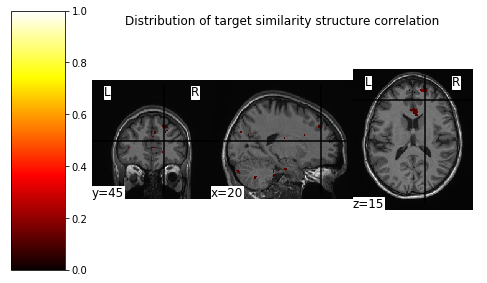

In [20]:
# plot the spatial distribution using NiPy
vol = betas.a.mapper.reverse1(slres_tdsm.samples[0])
import nibabel as nb
anat = nb.load('derivatives/fmriprep/sub-301/anat/sub-301_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')

from nipy.labs.viz_tools.activation_maps import plot_map
pl.figure(figsize=(15, 4))
sp = pl.subplot(121)
pl.title('Distribution of target similarity structure correlation')
slices = plot_map(
            vol,
            betas.a.imgaffine,
            cut_coords=np.array((20, 45, 15)),
            threshold=.1,
            cmap="hot",
            vmin=0,
            vmax=1.,
            axes=sp,
            anat=anat.get_data(),
            anat_affine=anat.affine,
         )
img = pl.gca().get_images()[1]
cax = pl.axes([.05, .05, .05, .9])
pl.colorbar(img, cax=cax)

"""sp = pl.subplot(122)
pl.hist(slres_tdsm.samples[0])
        #normed=False,
        #bins=30,
        #color='0.6')
pl.ylabel("Number of voxels")
pl.xlabel("Target similarity structure correlation")"""

In [21]:
import nibabel as nib

img = nib.Nifti1Image(vol, np.eye(4))
#nib.save(img, os.path.join(output_dir, 'sub301_sl_comp1.nii.gz')) 

# Searchlight RSA for All Subjects - Subject-level

In [22]:
# Define searchlight
tdsm = rsa.Regression(comps_all, normalize=True)
sl_tdsm = sphere_searchlight(tdsm, 4)

In [24]:
print("Running subject ...")
for subj in subjs_list:
    print("..."+subj)
    file_list = glob.glob(os.path.join(data_dir, subj, 'beta*nii'))
    file_list.sort()
    file_list = file_list[:-2]
    
    subj_mni_mask = "derivatives/reliability_analysis/relscenarios/Anatomy/"+subj+"_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz"
    
    betas = fmri_dataset(file_list, mask=subj_mni_mask)
    betas.sa.targets = np.array(conditions)
    
    slres_tdsm = sl_tdsm(betas)
    
    for n in range(1,5):
        vol = betas.a.mapper.reverse1(slres_tdsm.samples[n-1])
        img = nib.Nifti1Image(vol, betas.a.imgaffine)
        nib.save(img, os.path.join('derivatives/rsa_pymvpa/multireg_comp_maps', subj+'_sl_comp'+str(n)+'.nii.gz')) 

Running subject ...
...sub-301
...sub-651
...sub-653
...sub-693
...sub-697
...sub-699
...sub-700
...sub-701
...sub-706
...sub-715
...sub-716
...sub-720
...sub-721
...sub-722
...sub-723
...sub-724
...sub-726
...sub-727
...sub-730
...sub-738
...sub-739
...sub-740
...sub-743
...sub-745
...sub-747
...sub-749
...sub-751
...sub-754
...sub-759
...sub-761
...sub-762
...sub-763
...sub-764
...sub-765
...sub-766
...sub-767


# Searchlight RSA for All Subjects - Group-level

In [23]:
file_list = glob.glob(os.path.join(data_dir, 'group', 'cond*tmap.nii'))
file_list.sort()
#file_list = file_list[:-2]
    
subj_mni_mask = "derivatives/reliability_analysis/relscenarios/Anatomy/"+subj+"_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz"
    
tmaps = fmri_dataset(file_list, mask=subj_mni_mask)
tmaps.sa.targets = np.array(conditions)
    
slres_tdsm_group = sl_tdsm(tmaps)
    
for n in range(1,5):
    vol = tmaps.a.mapper.reverse1(slres_tdsm_group.samples[n-1])
    img = nib.Nifti1Image(vol, tmaps.a.imgaffine)
    nib.save(img, os.path.join(output_dir, 'group_sl_comp'+str(n)+'.nii.gz'))

In [220]:
img = nib.Nifti1Image(vol, np.eye(4))
img.affine

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [226]:
betas.a.imgaffine

array([[   2.51200008,    0.        ,    0.        ,  -96.        ],
       [   0.        ,    2.51200008,    0.        , -132.        ],
       [   0.        ,    0.        ,    2.5       ,  -78.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])